In [1]:
#初始化
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastbook import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.8 MB/s eta 0:00:00
Mounted at /content/gdrive


In [2]:
# 加载数据集
from fastai.vision.all import *
path = untar_data(URLs.PETS)
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

In [5]:
# 注释目录包含有关宠物位置而不是宠物是什么的信息
fname = (path/"images").ls()

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_40.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Egyptian_Mau_50.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_107.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Abyssinian_123.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/miniature_pinscher_54.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/havanese_115.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Birman_168.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_cocker_spaniel_137.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/english_setter_42.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_53.jpg')...]

In [9]:
fname = (path/"images").ls()[0]
fname

Path('/root/.fastai/data/oxford-iiit-pet/images/beagle_40.jpg')

In [10]:
# 测试正则表达式
re.findall(r'(.+)_\d+.jpg$', fname.name)

['beagle']

In [3]:
# 创建一个 DataBlock 对象，然后使用该对象来创建 DataLoaders 对象，用于图像分类任务。
pets = DataBlock(
    # 定义了数据的类型。ImageBlock 表示输入数据是图像，CategoryBlock 表示标签（目标变量）是分类类型。
    blocks = (ImageBlock, CategoryBlock),
    # 用于从提供的路径中获取图像文件。get_image_files 是一个内置函数，它会递归地从提供的路径中获取所有的图像文件。
    get_items=get_image_files,
    # 用于将数据集分割为训练集和验证集。RandomSplitter 是一个内置函数，它会随机地将数据集分割为训练集和验证集。
    splitter=RandomSplitter(seed=42),
    # 用于从图像文件中获取标签。RegexLabeller(r'(.+)_\d+.jpg) 会使用正则表达式从图像文件的名称中提取标签，using_attr( ..., 'name') 表示从文件名中提取标签。
    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
    # 包含了要对每个单独的图像应用的转换。Resize(460) 表示将每个图像的大小调整为 460x460。
    item_tfms=Resize(460),
    # 包含了要对每个批次的图像应用的转换。size=224表示将每个图像的大小调整为 224x224。min_scale=0.75 表示在随机裁剪图像时，裁剪的区域至少包含原始图像的 75%。
    batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

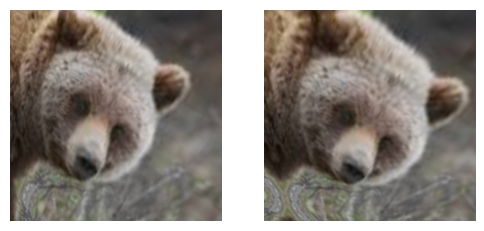

In [18]:
# 预处理
dblock1 = DataBlock(blocks=(ImageBlock(), CategoryBlock()),
                   get_y=parent_label,
                   item_tfms=Resize(460))
# 所有的图像都是同一张图像（'grizzly.jpg'）的复制，并且将批量大小（batch size）设为8
dls1 = dblock1.dataloaders([(Path.cwd()/'images'/'grizzly.jpg')]*100, bs=8)
# 每次训练时，都会使用相同的索引
dls1.train.get_idxs = lambda: Inf.ones
# 取出了一个批次的验证数据
x,y = dls1.valid.one_batch()
# 创建了两个子图
_,axs = subplots(1, 2)

# 对图像进行了一系列的数据增强操作，包括坐标仿射、旋转、缩放和扭曲。
x1 = TensorImage(x.clone())
x1 = x1.affine_coord(sz=224)
x1 = x1.rotate(draw=30, p=1.)
x1 = x1.zoom(draw=1.2, p=1.)
x1 = x1.warp(draw_x=-0.2, draw_y=0.2, p=1.)

# 创建了一个数据增强的管道，并将原始图像通过这个管道进行了处理。
tfms = setup_aug_tfms([Rotate(draw=30, p=1, size=224), Zoom(draw=1.2, p=1., size=224),
                       Warp(draw_x=-0.2, draw_y=0.2, p=1., size=224)])
x = Pipeline(tfms)(x)

# 将增强后的图像显示在子图上
#x.affine_coord(coord_tfm=coord_tfm, sz=size, mode=mode, pad_mode=pad_mode)
TensorImage(x[0]).show(ctx=axs[0])
TensorImage(x1[0]).show(ctx=axs[1]);

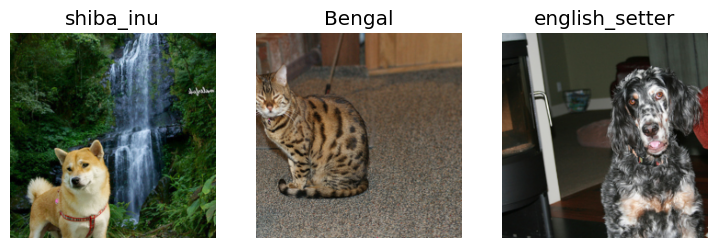

In [23]:
# 检查数据, 网络搜索几个品种,判断标签有无异常
dls.show_batch(nrows=1, ncols=3)

In [26]:
pets1 = DataBlock(blocks = (ImageBlock, CategoryBlock),
                    get_items=get_image_files,
                    splitter=RandomSplitter(seed=42),
                    get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                    item_tfms=Resize(460),
                    batch_tfms=aug_transforms(size=224, min_scale=0.75))
# 如要调试构建DataBlock时是否犯了错，建议使用 summary 方法。它将尝试从提供给它的源创建一个批处理，其中包含很多详细信息
pets1.summary(path/"images")

Setting-up type transforms pipelines
Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_109.jpg
    applying PILBase.create gives
      PILImage mode=RGB size=500x375
  Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
    starting from
      /root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_109.jpg
    applying partial gives
      scottish_terrier
    applying Categorize -- {'vocab': None, 'sort': True, 'add_na': False} gives
      TensorCategory(32)

Final sample: (PILImage mode=RGB size=500x375, TensorCategory(32))


Found 7390 items
2 datasets of sizes 5912,1478
Setting up Pipeline: PILBase.create
Setting up Pipeline: partial -> Categorize -- {'vocab': None, 'sort': True, 'add_na': False}
S

In [5]:
x, y = dls.one_batch()
y

TensorCategory([14, 26, 35,  6,  3,  0,  4, 19, 34,  0, 25, 22, 23, 23,  9, 33, 24, 23,  8,  6,  4, 24, 21, 34, 12, 22, 23,  8,  5,  9, 14, 18, 30, 25, 32, 32, 17, 22,  8, 29, 26,  8, 35, 22, 21, 33,
                34, 21, 28, 18,  8,  8, 25, 10, 17, 11, 30,  9,  9,  3, 13, 32, 19, 10], device='cuda:0')

In [4]:
# 训练一个简单的模型
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:02<00:00, 43.6MB/s]


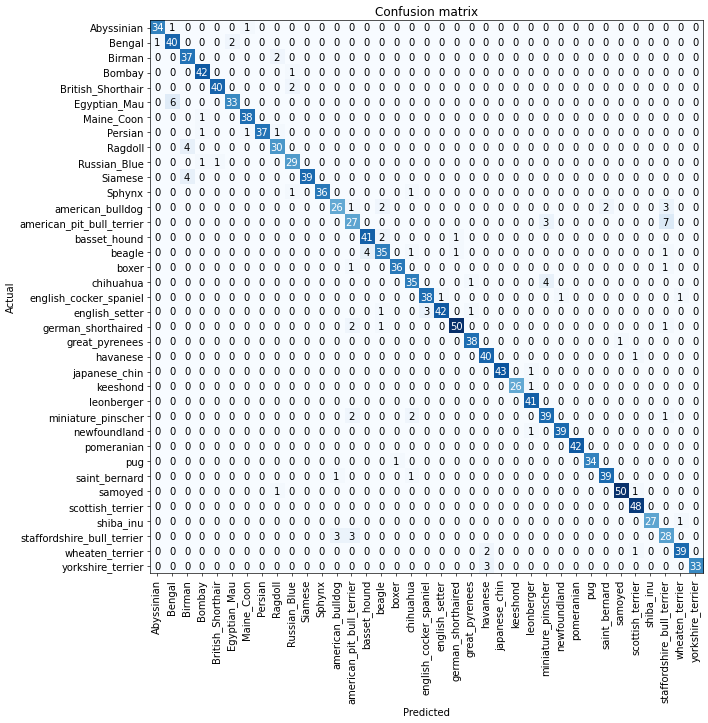

In [10]:
# 混淆矩阵
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [11]:
interp.most_confused(min_val=5)
# 不清楚混淆矩阵代表什么含义

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 7),
 ('Egyptian_Mau', 'Bengal', 6)]

In [12]:
# 学习率查找器
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1, base_lr=0.1)

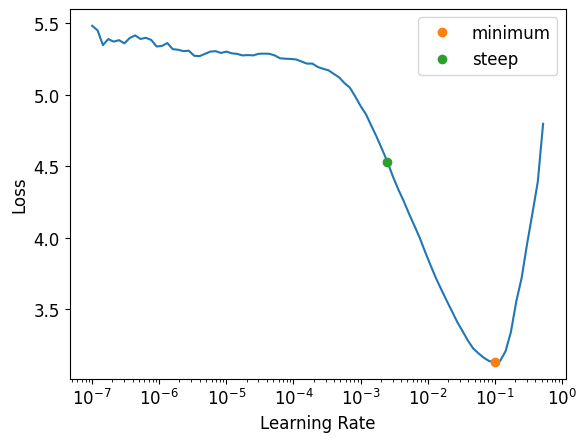

In [13]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [14]:
print(f"Minimum/10: {lr_min:.2e}, steepest point: {lr_steep:.2e}")
# 1e-1 已经太高了：在这个阶段，我们已经离开了损失稳步下降的时期。学习率似乎在 3e-3 左右是合适的，

Minimum/10: 1.00e-02, steepest point: 2.51e-03


In [15]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2, base_lr=3e-3)

In [17]:
# 解冻和迁移学习
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)

In [18]:
learn.unfreeze()

SuggestedLRs(valley=0.00010964782268274575)

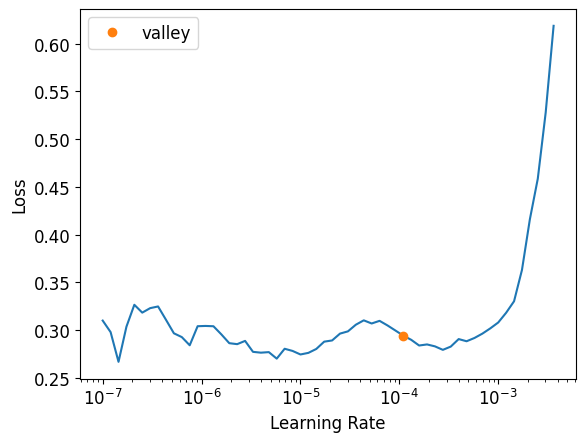

In [19]:
learn.lr_find()

In [20]:
learn.fit_one_cycle(6, lr_max=1e-5)

In [21]:
# 对神经网络的早期层使用较低的学习率，对后期层（尤其是随机添加的层）使用较高的学习率。
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fit_one_cycle(3, 3e-3)
learn.unfreeze()
learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

In [4]:
from fastai.callback.fp16 import *
learn = vision_learner(dls, resnet50, metrics=error_rate).to_fp16()
learn.fine_tune(6, freeze_epochs=3)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 60.0MB/s]
